In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import *

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool


test_df = pd.read_csv('./test.csv')
train_df = pd.read_csv('./train.csv')

# 전처리
## 결측치

In [93]:
# 결측치 확인
print(train_df.isnull().sum())
print(test_df.isnull().sum())

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64
index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       3152
family_size         0
begin_month         0
dtype: int64


In [94]:
train_df

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0
26453,26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NaN,2.0,-47.0,2.0
26454,26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0
26455,26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0


In [95]:
print(train_df[train_df['occyp_type'].isnull()==True]['income_type'].value_counts())


Pensioner               4440
Working                 2312
Commercial associate    1026
State servant            392
Student                    1
Name: income_type, dtype: int64


In [96]:
# occyp_type의 결측치 중, income_type이 Pensioner인 경우 
# occyp_type을 Pensioner로 채워준다.


train_p = train_df['income_type'] == 'Pensioner'
train_s = train_df['occyp_type'].isnull() == True
train_df.loc[(train_p & train_s), 'occyp_type'] = "Pensioner"


test_p = test_df['income_type'] == 'Pensioner'
test_s = test_df['occyp_type'].isnull() == True
test_df.loc[(test_p & test_s), 'occyp_type'] = "Pensioner"

print(train_df.info(), test_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     22726 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [97]:
# 결측치 재확인
print(train_df.isnull().sum())

print(test_df.isnull().sum())

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       3731
family_size         0
begin_month         0
credit              0
dtype: int64
index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       1453
family_size         0
begin_month         0
dtype: int64


In [98]:
# 결측치 제거
train_df = train_df.dropna()
test_df = test_df.dropna()

## 중복값

In [99]:
# 중복 데이터 확인
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())

# 중복값은 존재하지 않는다.

0
0


## 이상치 제거 (보류)

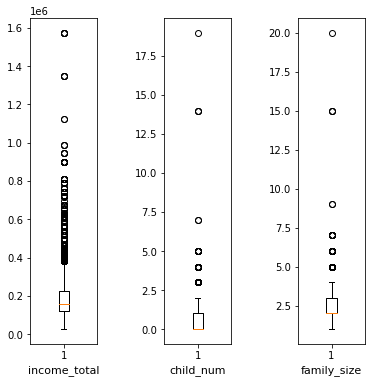

In [100]:
# numeric 변수 이상치 파악
fig, axes = plt.subplots(1,3)
plt.subplots_adjust(wspace = 1, hspace = 1)
fig.set_size_inches((6, 6))

axes[0].boxplot(train_df['income_total'])
axes[0].set_xlabel('income_total', fontsize = 11)


axes[1].boxplot(train_df['child_num'])
axes[1].set_xlabel('child_num', fontsize = 11)


axes[2].boxplot(train_df['family_size'])
axes[2].set_xlabel('family_size', fontsize = 11)

plt.show()

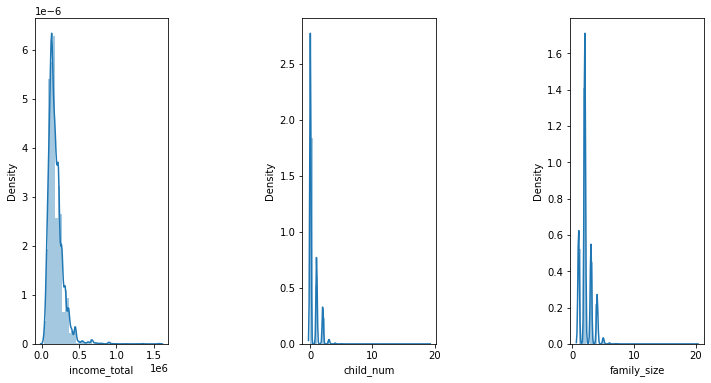

In [101]:
# numeric 변수 분포 살펴보기
fig, ax = plt.subplots(1,3)
plt.subplots_adjust(wspace = 1, hspace = 1)
fig.set_size_inches((12, 6))


sns.distplot(train_df['income_total'], ax=ax[0])
sns.distplot(train_df['child_num'], ax=ax[1])
sns.distplot(train_df['family_size'], ax=ax[2])

plt.show()

In [102]:
train_df.describe()

,index,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
count,22726.000000,22726.000000,2.272600e+04,22726.000000,22726.000000,22726.0,22726.000000,22726.000000,22726.000000,22726.000000,22726.000000,22726.000000
mean,13241.567940,0.420004,1.864634e+05,-16142.302033,69222.924448,1.0,0.219088,0.291032,0.089369,2.184502,-26.002112,1.516193
std,7621.976657,0.747098,1.011258e+05,4263.669056,145843.196100,0.0,0.413638,0.454248,0.285282,0.918011,16.569419,0.703833
min,1.000000,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,6656.250000,0.000000,1.215000e+05,-19777.000000,-3052.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000,1.000000
50%,13268.000000,0.000000,1.575000e+05,-15798.000000,-1435.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000,2.000000
75%,19830.750000,1.000000,2.250000e+05,-12557.000000,-307.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000,2.000000
max,26456.000000,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,2.000000


### income_total
225,000(3사분위수값) - 121,500(1사분위수값) = 103,500

103,500 * 1.5 = 155,250(IQR)

157,500(2사분위수값) + 155,250(IQR) = 312,750


### child_num
19 = 1  /  14 = 3  /  7 = 2  /  5 = 10  /  4 = 47  /  3 = 306  /  2 = 2362
1 = 5386  /  0 = 18340

2


### family_size
4

## 단위 변환

In [103]:
# 양수인 데이터는 무직자로 판단, 0으로 처리
train_df['DAYS_EMPLOYED'] = train_df['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)
test_df['DAYS_EMPLOYED'] = test_df['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)

# 365로 나누기
train_df['EM_YEAR_ALL'] = ((-train_df['DAYS_EMPLOYED']) // 365) + (round(((-train_df['DAYS_EMPLOYED'])%365) / 36.5,0) / 10)
train_df['EM_YEAR']= (-train_df['DAYS_EMPLOYED']) // 365

train_df['YEAR_BIRTH'] = (-train_df['DAYS_BIRTH']) // 365



test_df['EM_YEAR_ALL'] = ((-test_df['DAYS_EMPLOYED']) // 365) + (round(((-test_df['DAYS_EMPLOYED'])%365) / 36.5,0) / 10)
test_df['EM_YEAR']= (-test_df['DAYS_EMPLOYED']) // 365

test_df['YEAR_BIRTH'] = (-test_df['DAYS_BIRTH']) // 365

In [104]:
train_df

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,work_phone,phone,email,occyp_type,family_size,begin_month,credit,EM_YEAR_ALL,EM_YEAR,YEAR_BIRTH
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,...,0,0,1,Laborers,3.0,-5.0,1.0,4.2,4,31
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,...,0,1,0,Managers,2.0,-22.0,2.0,12.1,12,52
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,...,0,1,0,Sales staff,2.0,-37.0,0.0,5.7,5,41
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,...,0,0,0,Managers,2.0,-26.0,2.0,5.8,5,41
5,5,F,N,Y,2,270000.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,1,High skill tech staff,4.0,-18.0,1.0,13.7,13,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26451,26451,F,N,Y,0,202500.0,Working,Higher education,Married,House / apartment,...,1,1,0,Accountants,2.0,-44.0,1.0,2.2,2,35
26452,26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,...,0,0,0,Core staff,4.0,-2.0,1.0,5.4,5,33
26454,26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,...,0,0,0,Core staff,2.0,-25.0,2.0,5.5,5,27
26455,26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,...,0,0,0,Laborers,1.0,-59.0,2.0,0.3,0,27


## 컬럼 삭제

In [105]:
train_df.drop(['FLAG_MOBIL', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'index'], axis = 1, inplace = True)

test_df.drop(['FLAG_MOBIL', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'index'], axis = 1, inplace = True)

## 캐럿을 통한 알고리즘 추천

## 인코딩 작업

In [106]:
train_df

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,email,occyp_type,family_size,begin_month,credit,EM_YEAR_ALL,EM_YEAR,YEAR_BIRTH
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,0,0,1,Laborers,3.0,-5.0,1.0,4.2,4,31
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,0,1,0,Managers,2.0,-22.0,2.0,12.1,12,52
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,0,1,0,Sales staff,2.0,-37.0,0.0,5.7,5,41
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,0,0,0,Managers,2.0,-26.0,2.0,5.8,5,41
5,F,N,Y,2,270000.0,Working,Secondary / secondary special,Married,House / apartment,0,0,1,High skill tech staff,4.0,-18.0,1.0,13.7,13,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26451,F,N,Y,0,202500.0,Working,Higher education,Married,House / apartment,1,1,0,Accountants,2.0,-44.0,1.0,2.2,2,35
26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,0,0,0,Core staff,4.0,-2.0,1.0,5.4,5,33
26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,0,0,0,Core staff,2.0,-25.0,2.0,5.5,5,27
26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,0,0,0,Laborers,1.0,-59.0,2.0,0.3,0,27


In [107]:
# 젠더 값 인코딩
map_gender = {'M' : 0, 'F' : 1}
col = ['gender']
train_df[col] = train_df[col].applymap(map_gender.get)
test_df[col] = test_df[col].applymap(map_gender.get)


# 자동차 값 인코딩
map_car = {'Y' : 0, 'N' : 1}
col2 = ['car']
train_df[col2] = train_df[col2].applymap(map_car.get)
test_df[col2] = test_df[col2].applymap(map_car.get)



# 부동산 값 인코딩
map_reality = {'Y' : 0, 'N' : 1}
col3 = ['reality']
train_df[col3] = train_df[col3].applymap(map_reality.get)
test_df[col3] = test_df[col3].applymap(map_reality.get)



# 수입원천 값 인코딩
map_income_type = {'Commercial associate' : 1, 
                  'Pensioner' : 2,
                  'State servant' : 3,
                  'Student' : 4,
                  'Working' : 5}
col4 = ['income_type']
train_df[col4] = train_df[col4].applymap(map_income_type.get)
test_df[col4] = test_df[col4].applymap(map_income_type.get)



# 교육수준 값 인코딩
map_edu_type = {'Secondary / secondary special' : 1,
               'Lower secondary' : 2,
               'Incomplete higher' : 3,
               'Higher education' : 4,
               'Academic degree' : 5}
col5 = ['edu_type']
train_df[col5] = train_df[col5].applymap(map_edu_type.get)
test_df[col5] = test_df[col5].applymap(map_edu_type.get)



# 가족유형 값 인코딩
map_family_type = {'Widow' : 1,
                  'Single / not married' : 2,
                  'Separated' : 3,
                  'Civil marriage' : 4,
                  'Married' : 5}
col6 = ['family_type']
train_df[col6] = train_df[col6].applymap(map_family_type.get)
test_df[col6] = test_df[col6].applymap(map_family_type.get)



# 하우스 타입 값 인코딩
map_house_type = {'With parents' : 1, 
                 'Rented apartment' : 2,
                 'Office apartment' : 3,
                 'Municipal apartment' : 4,
                 'House / apartment' : 5,
                 'Co-op apartment' : 6}
col7 = ['house_type']
train_df[col7] = train_df[col7].applymap(map_house_type.get)
test_df[col7] = test_df[col7].applymap(map_house_type.get)



# 직업 값 인코딩
train_df['occyp_type'].replace(['Accountants', 'Cleaning staff','Cooking staff','Core staff','Drivers','High skill tech staff',
                            'HR staff','IT staff','Laborers','Low-skill Laborers', 'Managers','Medicine staff',
                            'Pensioner','Private service staff', 'Realty agents','Sales staff','Secretaries',
                            'Security staff','Waiters/barmen staff'],[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18],inplace=True)


test_df['occyp_type'].replace(['Accountants', 'Cleaning staff','Cooking staff','Core staff','Drivers','High skill tech staff',
                            'HR staff','IT staff','Laborers','Low-skill Laborers', 'Managers','Medicine staff',
                            'Pensioner','Private service staff', 'Realty agents','Sales staff','Secretaries',
                            'Security staff','Waiters/barmen staff'],[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18],inplace=True)

In [108]:
train_df

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,email,occyp_type,family_size,begin_month,credit,EM_YEAR_ALL,EM_YEAR,YEAR_BIRTH
1,1,1,0,1,247500.0,1,1,4,5,0,0,1,8,3.0,-5.0,1.0,4.2,4,31
2,0,0,0,0,450000.0,5,4,5,5,0,1,0,10,2.0,-22.0,2.0,12.1,12,52
3,1,1,0,0,202500.0,1,1,5,5,0,1,0,15,2.0,-37.0,0.0,5.7,5,41
4,1,0,0,0,157500.0,3,4,5,5,0,0,0,10,2.0,-26.0,2.0,5.8,5,41
5,1,1,0,2,270000.0,5,1,5,5,0,0,1,5,4.0,-18.0,1.0,13.7,13,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26451,1,1,0,0,202500.0,5,4,5,5,1,1,0,0,2.0,-44.0,1.0,2.2,2,35
26452,1,1,1,2,225000.0,3,1,5,5,0,0,0,3,4.0,-2.0,1.0,5.4,5,33
26454,1,0,1,0,292500.0,5,1,4,1,0,0,0,3,2.0,-25.0,2.0,5.5,5,27
26455,0,1,0,0,171000.0,5,3,2,5,0,0,0,8,1.0,-59.0,2.0,0.3,0,27


# 다중 선형 회귀 ML

In [109]:
# # 'occyp_type' 일단 제외

# train_df.drop(['occyp_type'], axis = 1, inplace = True)
# test_df.drop(['occyp_type'], axis = 1, inplace = True)


x = train_df[['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type', 'edu_type','family_type', 'house_type', 'work_phone', 'phone', 'email', 'occyp_type', 'family_size', 'begin_month', 'EM_YEAR_ALL', 'YEAR_BIRTH']]
y = train_df['credit']



print(x.shape, y.shape)

(22726, 17) (22726,)


In [110]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True, random_state = 20)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(18180, 17) (18180,)
(4546, 17) (4546,)


In [111]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

mlr = LinearRegression()
mlr.fit(x_train, y_train)

LinearRegression()

In [112]:
# 예측
y_predict = mlr.predict(x_test)
print('예측값 :', y_predict)

# 성능평가
y_acc = accuracy_score(y_test, y_predict)
print('정확도 :%.4f' %y_acc)

예측값 : [1.33752453 1.36355024 1.70932685 ... 1.43015174 1.64024483 1.41724232]


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [45]:
train_df

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,email,occyp_type,family_size,begin_month,credit,EM_YEAR_ALL,EM_YEAR,YEAR_BIRTH
1,1,1,0,1,247500.0,1,1,4,5,0,0,1,Laborers,3.0,-5.0,1.0,4.2,4,31
2,0,0,0,0,450000.0,5,4,5,5,0,1,0,Managers,2.0,-22.0,2.0,12.1,12,52
3,1,1,0,0,202500.0,1,1,5,5,0,1,0,Sales staff,2.0,-37.0,0.0,5.7,5,41
4,1,0,0,0,157500.0,3,4,5,5,0,0,0,Managers,2.0,-26.0,2.0,5.8,5,41
5,1,1,0,2,270000.0,5,1,5,5,0,0,1,High skill tech staff,4.0,-18.0,1.0,13.7,13,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26451,1,1,0,0,202500.0,5,4,5,5,1,1,0,Accountants,2.0,-44.0,1.0,2.2,2,35
26452,1,1,1,2,225000.0,3,1,5,5,0,0,0,Core staff,4.0,-2.0,1.0,5.4,5,33
26454,1,0,1,0,292500.0,5,1,4,1,0,0,0,Core staff,2.0,-25.0,2.0,5.5,5,27
26455,0,1,0,0,171000.0,5,3,2,5,0,0,0,Laborers,1.0,-59.0,2.0,0.3,0,27


In [ ]:
# a_side = ['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type', 'edu_type','family_type', 'house_type', 'work_phone', 'phone', 'email', 'occyp_type', 'family_size', 'begin_month', 'EM_YEAR_ALL', 'YEAR_BIRTH']
# b_side = ['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type', 'edu_type','family_type', 'house_type', 'work_phone', 'phone', 'email', 'occyp_type', 'family_size', 'begin_month', 'EM_YEAR_ALL', 'YEAR_BIRTH']
# c_side = ['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type', 'edu_type','family_type', 'house_type', 'work_phone', 'phone', 'email', 'occyp_type', 'family_size', 'begin_month', 'EM_YEAR_ALL', 'YEAR_BIRTH']
# d_side = ['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type', 'edu_type','family_type', 'house_type', 'work_phone', 'phone', 'email', 'occyp_type', 'family_size', 'begin_month', 'EM_YEAR_ALL', 'YEAR_BIRTH']


# for i in a_side:
    
#     for j in b_side:
#         if i == j:
#             pass
        
#         for z in c_side:
#             if i == z or j == z:
#                 pass
            
#             for k in d_side:
#                 if z == k or j == k or i == k:
#                     pass
                
#                 i, j, z, k